# Canny Edge Detection

## Theory
The Canny Edge detector was developed by John F. Canny in 1986. Also known to many as the optimal detector, Canny algorithm aims to satisfy three main criteria:
- **Low error rate**: Meaning a good detection of only existent edges.
- **Good localization**: The distance between edge pixels detected and real edge pixels have to be minimized.
- **Minimal response**: Only one detector response per edge

## Algorithm

Canny Edge Detection is based on the following steps:

    1.Grayscale Conversion
    2.Noise Reduction
    3.Determining Intensity Gradients
    4.Non-Maximum Suppression
    5.Edge Tracking by Double Threslholding Hysteresis
    

## Implementation

In [1]:
import numpy as np
import cv2 
from scipy import ndimage
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive
import ipywidgets as widgets

### 1. GrayScale Conversion

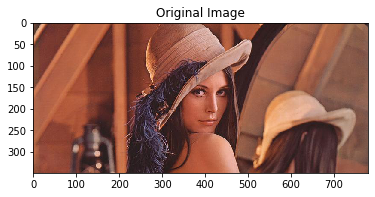

In [2]:
imgColor = cv2.imread('lenna.jpg')
plt.imshow(imgColor[...,::-1])
plt.title('Original Image')
plt.show()

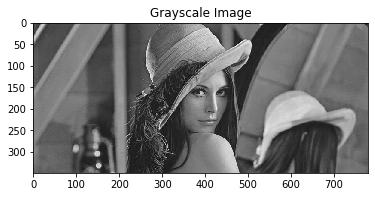

In [3]:
imgGray = cv2.cvtColor(imgColor, cv2.COLOR_BGR2GRAY)
# Normalize image
imgGray = imgGray/np.max(imgGray)
plt.imshow(imgGray, cmap = plt.get_cmap('gray'))
plt.title('Grayscale Image')
plt.show()

### 2. Noise reduction
To filter out any noise a **Gaussian Filter** is applied to the image. 
The blur removes some of the noise before further processing the image. 


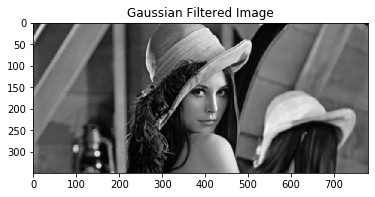

In [4]:
imgBlur= cv2.GaussianBlur(imgGray,(5,5),0)
plt.imshow(imgBlur, cmap = plt.get_cmap('gray'))
plt.title('Gaussian Filtered Image')
plt.show()

### 3. Intensity Gradients
To find the intensity gradient of the image, a **Sobel Filter** is applied to the smoothened image.

Apply a pair of convolution masks in vertical and horizontal directions

$$\begin{equation}
 \mathbf{G}_x = 
 \begin{bmatrix} 
 -1 & 0 & 1 \\ 
 -1 & 0 & 1 \\ 
 -1 & 0 & 1 
 \end{bmatrix}
Img
\end{equation}$$



$$\begin{equation}
\mathbf{G}_y = 
 \begin{bmatrix} 
 -1 & -2 & -1 \\ 
 0 & 0 & 0 \\ 
 -1 & 2 & 1 
 \end{bmatrix}
Img
\end{equation}$$

In [5]:
Gtx = np.array([[-1,0,1], [-2,0,2],  [-1,0,1]])
Gx = ndimage.convolve(imgBlur, Gtx)

Gty = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
Gy = ndimage.convolve(imgBlur, Gty)

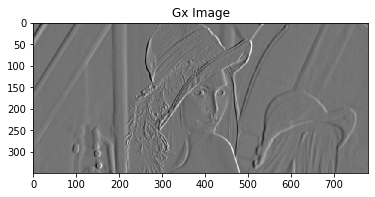

In [6]:
plt.imshow(Gx, cmap = plt.get_cmap('gray'))
plt.title('Gx Image')
plt.show()

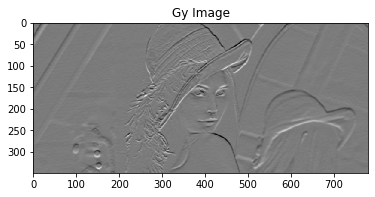

In [7]:
plt.imshow(Gy, cmap = plt.get_cmap('gray'))
plt.title('Gy Image')
plt.show()

Find the gradient magnitude and direction

$$
|G| = \sqrt{\mathbf{G}_x ^2 + \mathbf{G}_y ^2 }
$$

$$
\angle{G} = \arctan{\left(\frac{\mathbf{G}_y}{  \mathbf{G}_x}  \right)}
$$

In [8]:
Gmag = np.hypot(Gx,Gy)
Gangle = np.degrees(np.arctan2(Gy,Gx))

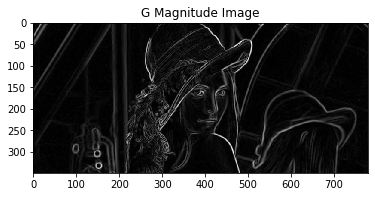

In [9]:
plt.imshow(Gmag, cmap = plt.get_cmap('gray'))
plt.title('G Magnitude Image')
plt.show()

### 4. Non-maximum suppression
This removes pixels that are not considered to be part of an edge. Hence, only thin lines (candidate edges) will remain.

Non maximum suppression works by finding the pixel with the maximum value in an edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient.

<img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/nms.jpg">

Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is considered for next stage, otherwise, it is suppressed ( put to zero).

In [10]:
M, N = Gmag.shape
Gnms = np.zeros((M,N))

for i in range(1, M-1):
    for j in range(1, N-1):
        
        if((Gangle[i,j] >= 0 and Gangle[i,j] <= 45) or (Gangle[i,j] < -135 and Gangle[i,j] >= -180)):
            
            yBottom = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
            yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
            x_est = np.absolute(Gy[i,j]/Gmag[i,j])
            
            if (Gmag[i,j] >= ((yBottom[1]-yBottom[0])*x_est+yBottom[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                Gnms[i,j] = Gmag[i,j]
            else:
                Gnms[i,j] = 0
                
        if((Gangle[i,j] > 45 and Gangle[i,j] <= 90) or (Gangle[i,j] < -90 and Gangle[i,j] >= -135)):
            
            yBottom = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
            yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
            x_est = np.absolute(Gx[i,j]/Gmag[i,j])
            
            if (Gmag[i,j] >= ((yBottom[1]-yBottom[0])*x_est+yBottom[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                Gnms[i,j] = Gmag[i,j]
            else:
                Gnms[i,j] = 0
                
        if((Gangle[i,j] > 90 and Gangle[i,j] <= 135) or (Gangle[i,j] < -45 and Gangle[i,j] >= -90)):
            
            yBottom = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
            yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
            x_est = np.absolute(Gx[i,j]/Gmag[i,j])
            
            if (Gmag[i,j] >= ((yBottom[1]-yBottom[0])*x_est+yBottom[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                Gnms[i,j] = Gmag[i,j]
            else:
                Gnms[i,j] = 0
                
        if((Gangle[i,j] > 135 and Gangle[i,j] <= 180) or (Gangle[i,j] < 0 and Gangle[i,j] >= -45)):
            
            yBottom = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
            yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
            x_est = np.absolute(Gy[i,j]/Gmag[i,j])
            
            if (Gmag[i,j] >= ((yBottom[1]-yBottom[0])*x_est+yBottom[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                Gnms[i,j] = Gmag[i,j]
            else:
                Gnms[i,j] = 0

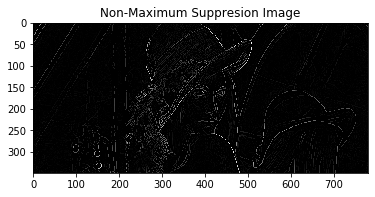

In [11]:
plt.imshow(Gnms, cmap = plt.get_cmap('gray'))
plt.title('Non-Maximum Suppresion Image')
plt.show()

### 5. Hysteresis Thresholding

Canny does use two thresholds (upper and lower):

1. If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
2. If a pixel gradient value is below the lower threshold, then it is rejected.
3. If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.

Note: _Canny recommended a upper:lower ratio between 2:1 and 3:1._

<img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/hysteresis.jpg">


#### 5.1 Double Thresholding

We notice that the result from non maximum suppression is not perfect, some edges may not actually be edges and there is some noise in the image. Double thresholding takes care of this. It sets two thresholds, a high and a low threshold. Pixels with a high value are most likely to be edges. 

In [12]:
highThresholdRatio = 0.2  
lowThresholdRatio = 0.1
weak_pixel=75
strong_pixel=255

highThreshold = Gnms.max() * highThresholdRatio;
lowThreshold = highThreshold * lowThresholdRatio;

M, N = Gnms.shape
Gthres = np.zeros((M,N), dtype=np.int32)

weak = np.int32(weak_pixel)
strong = np.int32(strong_pixel)

strong_i, strong_j = np.where(Gnms >= highThreshold)
zeros_i, zeros_j = np.where(Gnms < lowThreshold)

weak_i, weak_j = np.where((Gnms <= highThreshold) & (Gnms >= lowThreshold))

Gthres[strong_i, strong_j] = strong
Gthres[weak_i, weak_j] = weak

#### 5.2 Edge Tracking by Hysteresis
Now that we have determined what the strong edges and weak edges are, we need to determine which weak edges are actual edges. To do this, we perform an edge tracking algorithm. Weak edges that are connected to strong edges will be actual/real edges. Weak edges that are not connected to strong edges will be removed. To speed up this process, my algorithm keeps track of the weak and strong edges that way I can recursively iterate through the strong edges and see if there are connected weak edges instead of having to iterate through every pixel in the image.

In [13]:
imgEdges = Gthres
M, N = Gthres.shape
weak = weak_pixel
strong = strong_pixel

for i in range(1, M-1):
    for j in range(1, N-1):
        if (imgEdges[i,j] == weak):
            try:
                if ((imgEdges[i+1, j-1] == strong) or (imgEdges[i+1, j] == strong) or (imgEdges[i+1, j+1] == strong)
                    or (imgEdges[i, j-1] == strong) or (imgEdges[i, j+1] == strong)
                    or (imgEdges[i-1, j-1] == strong) or (imgEdges[i-1, j] == strong) or (imgEdges[i-1, j+1] == strong)):
                    imgEdges[i, j] = strong
                else:
                    imgEdges[i, j] = 0
            except IndexError as e:
                pass

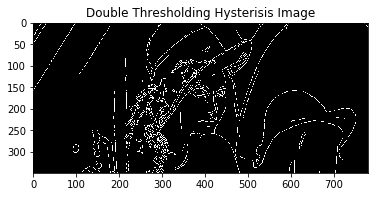

In [14]:
plt.imshow(imgEdges, cmap = plt.get_cmap('gray'))
plt.title('Double Thresholding Hysterisis Image')
plt.show()

## Canny Edge Detection in OpenCV


In [15]:
cvImgGray = cv2.imread('lenna.jpg',0)
edges = cv2.Canny(cvImgGray,100,200)

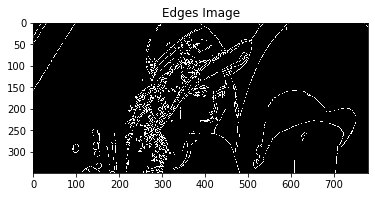

In [16]:
plt.imshow(edges, cmap = plt.get_cmap('gray'))
plt.title('Edges Image')
plt.show()